<a href="https://colab.research.google.com/github/evroth/gsb545repo/blob/main/Lab7_Bitcoin_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 7: Predicting Daily Bitcoin Stock

**Recurrent Neural Networks**

The goal of this lab is to use recurrent neural networks to predict bitcoin close price on the Saudi market (SAR/Sudi Riyal).

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
from plotnine import ggplot, geom_point, geom_smooth, aes, stat_smooth, geom_line, xlim, ylim

## The Data and Prep

In [67]:
bit = pd.read_csv("dc.csv")

In [68]:
bit

,Unnamed: 0,open_SAR,open_USD,high_SAR,high_USD,low_SAR,low_USD,close_SAR,close_USD,volume
0,2021-01-30,128437.248512,34246.28,131012.723200,34933.00,123106.880000,32825.00,128333.212416,34218.54,43072
1,2021-01-29,125144.022272,33368.18,144510.037760,38531.90,119695.516160,31915.40,128459.450880,34252.20,231827
2,2021-01-28,113870.357376,30362.19,126703.438592,33783.98,111919.811840,29842.10,125131.570944,33364.86,92621
3,2021-01-27,121753.023104,32464.01,122102.860416,32557.29,109668.146688,29241.72,113885.208960,30366.15,95911
4,2021-01-26,120966.114176,32254.19,123470.218752,32921.88,115652.472448,30837.37,121767.124608,32467.77,84972
...,...,...,...,...,...,...,...,...,...,...
995,2018-05-11,33761.888384,9002.21,33816.606720,9016.80,31282.086400,8341.00,31503.360000,8400.00,48227
996,2018-05-10,34916.224000,9310.00,35235.458048,9395.12,33641.088000,8970.00,33761.850880,9002.20,25055
997,2018-05-09,34421.171200,9178.00,35216.256000,9390.00,33622.336000,8965.00,34916.224000,9310.00,25673
998,2018-05-08,35122.496000,9365.00,35537.665280,9475.70,33980.649216,9060.54,34457.025024,9187.56,25533


Order the data properly.

In [69]:
bit['date'] = pd.to_datetime(bit['Unnamed: 0'])

# Sort the DataFrame based on the 'bit' column in ascending order
bit.sort_values(by='date', inplace=True)

# Reset the index of the DataFrame if needed
bit.reset_index(drop=True, inplace=True)

In [70]:
bit

,Unnamed: 0,open_SAR,open_USD,high_SAR,high_USD,low_SAR,low_USD,close_SAR,close_USD,volume,date
0,2018-05-07,36232.689408,9661.02,36340.138368,9689.67,34432.422400,9181.00,35122.496000,9365.00,33787,2018-05-07
1,2018-05-08,35122.496000,9365.00,35537.665280,9475.70,33980.649216,9060.54,34457.025024,9187.56,25533,2018-05-08
2,2018-05-09,34421.171200,9178.00,35216.256000,9390.00,33622.336000,8965.00,34916.224000,9310.00,25673,2018-05-09
3,2018-05-10,34916.224000,9310.00,35235.458048,9395.12,33641.088000,8970.00,33761.850880,9002.20,25055,2018-05-10
4,2018-05-11,33761.888384,9002.21,33816.606720,9016.80,31282.086400,8341.00,31503.360000,8400.00,48227,2018-05-11
...,...,...,...,...,...,...,...,...,...,...,...
995,2021-01-26,120966.114176,32254.19,123470.218752,32921.88,115652.472448,30837.37,121767.124608,32467.77,84972,2021-01-26
996,2021-01-27,121753.023104,32464.01,122102.860416,32557.29,109668.146688,29241.72,113885.208960,30366.15,95911,2021-01-27
997,2021-01-28,113870.357376,30362.19,126703.438592,33783.98,111919.811840,29842.10,125131.570944,33364.86,92621,2021-01-28
998,2021-01-29,125144.022272,33368.18,144510.037760,38531.90,119695.516160,31915.40,128459.450880,34252.20,231827,2021-01-29


save just the column we want to predict

In [71]:
df = bit["close_USD"]

df = df.to_frame()

In [72]:
df

,close_USD
0,9365.00
1,9187.56
2,9310.00
3,9002.20
4,8400.00
...,...
995,32467.77
996,30366.15
997,33364.86
998,34252.20


## Set Up

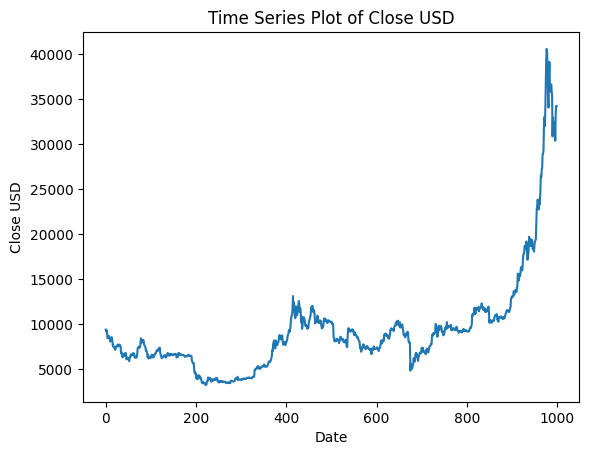

In [26]:
# Plot the 'close_usd' column as a time series plot
df['close_USD'].plot()

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Close USD')
plt.title('Time Series Plot of Close USD')

# Display the plot
plt.show()

In [28]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
df2 = scaler.fit_transform(df)

train_size = int(len(df2) * 0.8)
test_size = len(df2) - train_size
train, test = df2[0:train_size], df2[train_size:len(df2)]
print(len(train), len(test))

800 200


## Modeling

In [27]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
      a = dataset[i:(i+look_back), 0]
      dataX.append(a)
      dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

**Model w look back = 4**

In [29]:
# reshape into X=t and Y=t+1
look_back = 4
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [30]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [31]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
795/795 - 4s - loss: 7.9988e-04 - 4s/epoch - 6ms/step
Epoch 2/100
795/795 - 1s - loss: 1.2853e-04 - 1s/epoch - 2ms/step
Epoch 3/100
795/795 - 1s - loss: 1.2113e-04 - 1s/epoch - 2ms/step
Epoch 4/100
795/795 - 1s - loss: 1.2099e-04 - 1s/epoch - 2ms/step
Epoch 5/100
795/795 - 1s - loss: 1.1682e-04 - 1s/epoch - 2ms/step
Epoch 6/100
795/795 - 1s - loss: 1.0586e-04 - 1s/epoch - 2ms/step
Epoch 7/100
795/795 - 1s - loss: 1.0644e-04 - 1s/epoch - 2ms/step
Epoch 8/100
795/795 - 2s - loss: 1.0407e-04 - 2s/epoch - 2ms/step
Epoch 9/100
795/795 - 2s - loss: 1.0169e-04 - 2s/epoch - 3ms/step
Epoch 10/100
795/795 - 1s - loss: 9.9302e-05 - 1s/epoch - 2ms/step
Epoch 11/100
795/795 - 1s - loss: 9.2922e-05 - 1s/epoch - 2ms/step
Epoch 12/100
795/795 - 1s - loss: 9.0305e-05 - 1s/epoch - 2ms/step
Epoch 13/100
795/795 - 1s - loss: 8.6051e-05 - 1s/epoch - 2ms/step
Epoch 14/100
795/795 - 1s - loss: 9.1264e-05 - 1s/epoch - 2ms/step
Epoch 15/100
795/795 - 1s - loss: 8.6318e-05 - 1s/epoch - 2ms/step
Epoc

In [32]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

7/7 [==============================] - 0s 7ms/step
Train Score: 311.91 RMSE
Test Score: 3569.36 RMSE


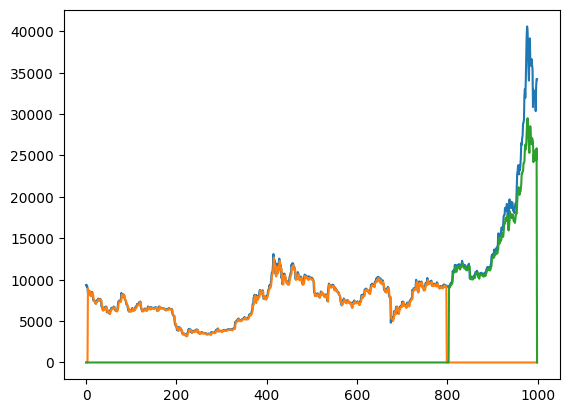

In [34]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df2)
#trainPredictPlot[:, :] = np.nan
trainPredictPlot[:, :] = 0
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df2)
#testPredictPlot[:, :] = np.nan
testPredictPlot[:, :] = 0
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df2)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df2))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [35]:
finalprice = np.append(scaler.inverse_transform(df2).flatten(), trainPredictPlot.flatten())
finalprice = np.append(finalprice, testPredictPlot.flatten())

finallabels = np.append(["Original"]*len(trainPredictPlot), ["Train"]*len(trainPredictPlot))
finallabels = np.append(finallabels, ["Test"]*len(trainPredictPlot))

finaltime = np.append(range(len(trainPredictPlot)), range(len(trainPredictPlot)))
finaltime = np.append(finaltime, range(len(trainPredictPlot)))

results = pd.DataFrame(data = 
    {'timeindex': finaltime,
    'ma': finalprice,
    'label': finallabels}
)


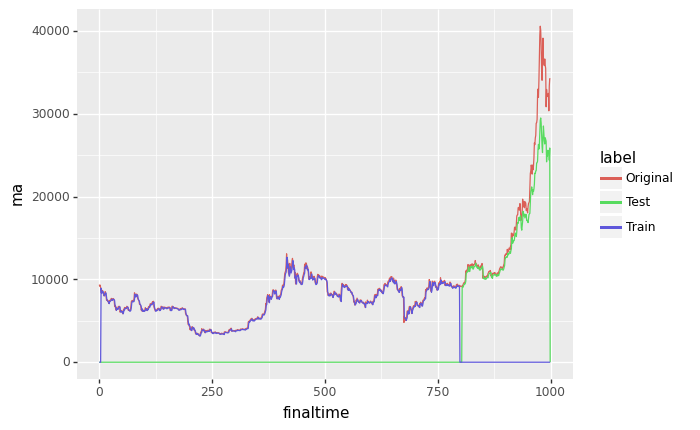

<ggplot: (8742388887586)>

In [36]:
(ggplot(results, aes("finaltime", "ma", color = "label"))
 + geom_line())

**Model w look back = 2**

In [37]:
# reshape into X=t and Y=t+1
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [38]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [39]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
797/797 - 4s - loss: 0.0013 - 4s/epoch - 5ms/step
Epoch 2/100
797/797 - 2s - loss: 8.8679e-05 - 2s/epoch - 2ms/step
Epoch 3/100
797/797 - 2s - loss: 8.5543e-05 - 2s/epoch - 2ms/step
Epoch 4/100
797/797 - 1s - loss: 8.3206e-05 - 1s/epoch - 2ms/step
Epoch 5/100
797/797 - 2s - loss: 9.0090e-05 - 2s/epoch - 2ms/step
Epoch 6/100
797/797 - 2s - loss: 8.3325e-05 - 2s/epoch - 2ms/step
Epoch 7/100
797/797 - 1s - loss: 8.8366e-05 - 1s/epoch - 2ms/step
Epoch 8/100
797/797 - 1s - loss: 8.5175e-05 - 1s/epoch - 2ms/step
Epoch 9/100
797/797 - 1s - loss: 8.6520e-05 - 1s/epoch - 2ms/step
Epoch 10/100
797/797 - 1s - loss: 8.3424e-05 - 1s/epoch - 2ms/step
Epoch 11/100
797/797 - 1s - loss: 8.6063e-05 - 1s/epoch - 2ms/step
Epoch 12/100
797/797 - 1s - loss: 8.0955e-05 - 1s/epoch - 2ms/step
Epoch 13/100
797/797 - 1s - loss: 8.2716e-05 - 1s/epoch - 2ms/step
Epoch 14/100
797/797 - 2s - loss: 8.1912e-05 - 2s/epoch - 3ms/step
Epoch 15/100
797/797 - 2s - loss: 7.9267e-05 - 2s/epoch - 2ms/step
Epoch 16

In [40]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

7/7 [==============================] - 0s 6ms/step
Train Score: 319.65 RMSE
Test Score: 3198.24 RMSE


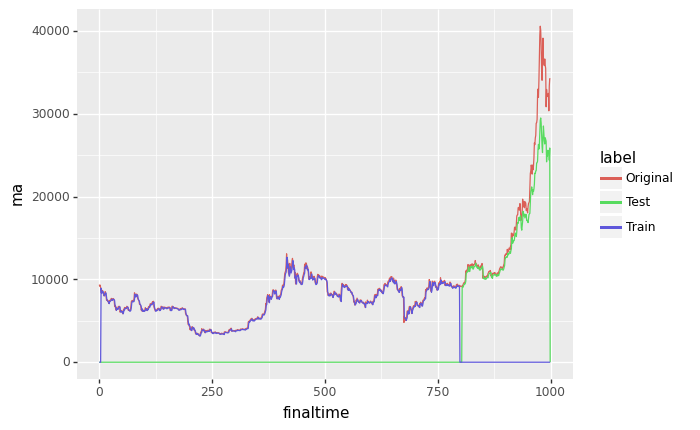

<ggplot: (8742387595448)>

In [41]:
finalprice = np.append(scaler.inverse_transform(df2).flatten(), trainPredictPlot.flatten())
finalprice = np.append(finalprice, testPredictPlot.flatten())

finallabels = np.append(["Original"]*len(trainPredictPlot), ["Train"]*len(trainPredictPlot))
finallabels = np.append(finallabels, ["Test"]*len(trainPredictPlot))

finaltime = np.append(range(len(trainPredictPlot)), range(len(trainPredictPlot)))
finaltime = np.append(finaltime, range(len(trainPredictPlot)))

results = pd.DataFrame(data = 
    {'timeindex': finaltime,
    'ma': finalprice,
    'label': finallabels}
)

(ggplot(results, aes("finaltime", "ma", color = "label"))
 + geom_line())

This model outperforms the model with a look-back of 4.

**Model with lookback of 1 and using LSTM**


In [47]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [48]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [49]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
798/798 - 4s - loss: 0.0029 - 4s/epoch - 5ms/step
Epoch 2/100
798/798 - 1s - loss: 4.5038e-04 - 1s/epoch - 2ms/step
Epoch 3/100
798/798 - 1s - loss: 7.8140e-05 - 1s/epoch - 2ms/step
Epoch 4/100
798/798 - 1s - loss: 7.5921e-05 - 1s/epoch - 2ms/step
Epoch 5/100
798/798 - 2s - loss: 7.9742e-05 - 2s/epoch - 2ms/step
Epoch 6/100
798/798 - 2s - loss: 7.8824e-05 - 2s/epoch - 2ms/step
Epoch 7/100
798/798 - 1s - loss: 7.9529e-05 - 1s/epoch - 2ms/step
Epoch 8/100
798/798 - 1s - loss: 7.6742e-05 - 1s/epoch - 2ms/step
Epoch 9/100
798/798 - 1s - loss: 7.9427e-05 - 1s/epoch - 2ms/step
Epoch 10/100
798/798 - 1s - loss: 8.1696e-05 - 1s/epoch - 2ms/step
Epoch 11/100
798/798 - 1s - loss: 7.6838e-05 - 1s/epoch - 2ms/step
Epoch 12/100
798/798 - 2s - loss: 7.9641e-05 - 2s/epoch - 2ms/step
Epoch 13/100
798/798 - 2s - loss: 7.6565e-05 - 2s/epoch - 2ms/step
Epoch 14/100
798/798 - 2s - loss: 7.7396e-05 - 2s/epoch - 2ms/step
Epoch 15/100
798/798 - 1s - loss: 8.1391e-05 - 1s/epoch - 2ms/step
Epoch 16

In [50]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

7/7 [==============================] - 0s 3ms/step
Train Score: 306.47 RMSE
Test Score: 3028.19 RMSE


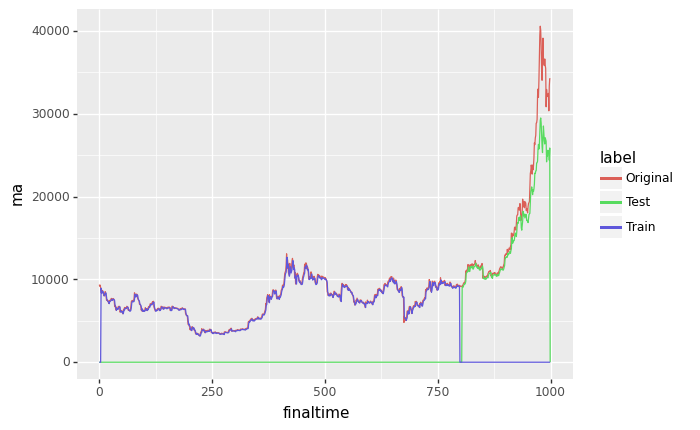

<ggplot: (8742386543571)>

In [51]:
finalprice = np.append(scaler.inverse_transform(df2).flatten(), trainPredictPlot.flatten())
finalprice = np.append(finalprice, testPredictPlot.flatten())

finallabels = np.append(["Original"]*len(trainPredictPlot), ["Train"]*len(trainPredictPlot))
finallabels = np.append(finallabels, ["Test"]*len(trainPredictPlot))

finaltime = np.append(range(len(trainPredictPlot)), range(len(trainPredictPlot)))
finaltime = np.append(finaltime, range(len(trainPredictPlot)))

results = pd.DataFrame(data = 
    {'timeindex': finaltime,
    'ma': finalprice,
    'label': finallabels}
)

(ggplot(results, aes("finaltime", "ma", color = "label"))
 + geom_line())

**Model with lookback of 1 and using SimpleRNN**


In [42]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [43]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [44]:
# create and fit the LSTM network
model = Sequential()
model.add(SimpleRNN(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
798/798 - 3s - loss: 6.4957e-04 - 3s/epoch - 4ms/step
Epoch 2/100
798/798 - 1s - loss: 7.5888e-05 - 1s/epoch - 1ms/step
Epoch 3/100
798/798 - 1s - loss: 7.7078e-05 - 1s/epoch - 1ms/step
Epoch 4/100
798/798 - 1s - loss: 7.9682e-05 - 1s/epoch - 2ms/step
Epoch 5/100
798/798 - 1s - loss: 8.5304e-05 - 1s/epoch - 2ms/step
Epoch 6/100
798/798 - 1s - loss: 7.8841e-05 - 1s/epoch - 2ms/step
Epoch 7/100
798/798 - 1s - loss: 8.0597e-05 - 1s/epoch - 2ms/step
Epoch 8/100
798/798 - 1s - loss: 8.6073e-05 - 1s/epoch - 2ms/step
Epoch 9/100
798/798 - 2s - loss: 8.2768e-05 - 2s/epoch - 2ms/step
Epoch 10/100
798/798 - 2s - loss: 8.1323e-05 - 2s/epoch - 2ms/step
Epoch 11/100
798/798 - 1s - loss: 8.2789e-05 - 1s/epoch - 2ms/step
Epoch 12/100
798/798 - 1s - loss: 7.6774e-05 - 1s/epoch - 2ms/step
Epoch 13/100
798/798 - 1s - loss: 8.0610e-05 - 1s/epoch - 2ms/step
Epoch 14/100
798/798 - 1s - loss: 7.9203e-05 - 1s/epoch - 2ms/step
Epoch 15/100
798/798 - 1s - loss: 7.8492e-05 - 1s/epoch - 2ms/step
Epoc

In [45]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

7/7 [==============================] - 0s 2ms/step
Train Score: 300.02 RMSE
Test Score: 1789.49 RMSE


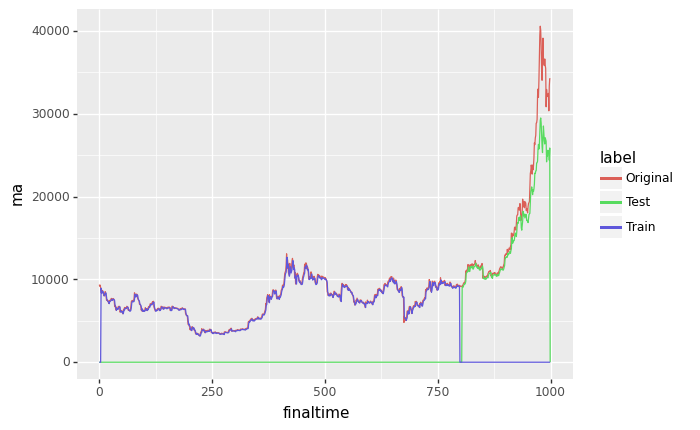

<ggplot: (8742387405623)>

In [46]:
finalprice = np.append(scaler.inverse_transform(df2).flatten(), trainPredictPlot.flatten())
finalprice = np.append(finalprice, testPredictPlot.flatten())

finallabels = np.append(["Original"]*len(trainPredictPlot), ["Train"]*len(trainPredictPlot))
finallabels = np.append(finallabels, ["Test"]*len(trainPredictPlot))

finaltime = np.append(range(len(trainPredictPlot)), range(len(trainPredictPlot)))
finaltime = np.append(finaltime, range(len(trainPredictPlot)))

results = pd.DataFrame(data = 
    {'timeindex': finaltime,
    'ma': finalprice,
    'label': finallabels}
)

(ggplot(results, aes("finaltime", "ma", color = "label"))
 + geom_line())

**Final Model**

*See if I can improve the best model so far (simpleRnn w 10 nodes, lookback=1)*

*SimpleRNN w 4 nodes in hidden layer, lookback=1*

In [52]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [53]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [54]:
# create and fit the LSTM network
model = Sequential()
model.add(SimpleRNN(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
798/798 - 2s - loss: 0.0056 - 2s/epoch - 3ms/step
Epoch 2/100
798/798 - 1s - loss: 9.5198e-04 - 1s/epoch - 2ms/step
Epoch 3/100
798/798 - 1s - loss: 1.0413e-04 - 1s/epoch - 2ms/step
Epoch 4/100
798/798 - 1s - loss: 7.0832e-05 - 1s/epoch - 2ms/step
Epoch 5/100
798/798 - 2s - loss: 7.5077e-05 - 2s/epoch - 2ms/step
Epoch 6/100
798/798 - 3s - loss: 7.7509e-05 - 3s/epoch - 4ms/step
Epoch 7/100
798/798 - 1s - loss: 8.0028e-05 - 1s/epoch - 2ms/step
Epoch 8/100
798/798 - 2s - loss: 7.5318e-05 - 2s/epoch - 2ms/step
Epoch 9/100
798/798 - 3s - loss: 8.5424e-05 - 3s/epoch - 3ms/step
Epoch 10/100
798/798 - 2s - loss: 8.2407e-05 - 2s/epoch - 3ms/step
Epoch 11/100
798/798 - 2s - loss: 8.4940e-05 - 2s/epoch - 2ms/step
Epoch 12/100
798/798 - 2s - loss: 7.7396e-05 - 2s/epoch - 2ms/step
Epoch 13/100
798/798 - 2s - loss: 7.8384e-05 - 2s/epoch - 2ms/step
Epoch 14/100
798/798 - 1s - loss: 8.0457e-05 - 1s/epoch - 2ms/step
Epoch 15/100
798/798 - 1s - loss: 8.0219e-05 - 1s/epoch - 1ms/step
Epoch 16

In [55]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

7/7 [==============================] - 0s 3ms/step
Train Score: 344.01 RMSE
Test Score: 1250.14 RMSE


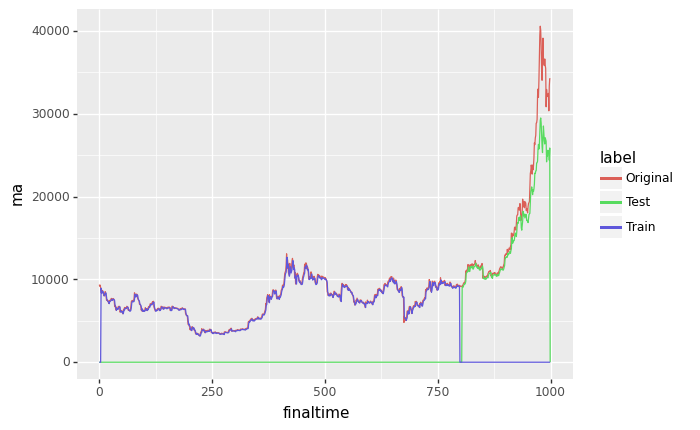

<ggplot: (8742386106125)>

In [56]:
finalprice = np.append(scaler.inverse_transform(df2).flatten(), trainPredictPlot.flatten())
finalprice = np.append(finalprice, testPredictPlot.flatten())

finallabels = np.append(["Original"]*len(trainPredictPlot), ["Train"]*len(trainPredictPlot))
finallabels = np.append(finallabels, ["Test"]*len(trainPredictPlot))

finaltime = np.append(range(len(trainPredictPlot)), range(len(trainPredictPlot)))
finaltime = np.append(finaltime, range(len(trainPredictPlot)))

results = pd.DataFrame(data = 
    {'timeindex': finaltime,
    'ma': finalprice,
    'label': finallabels}
)

(ggplot(results, aes("finaltime", "ma", color = "label"))
 + geom_line())

This final model was the best I was able to put together.

## Conclusion

With the Simple Recurrent Neural Net with 4 nodes, we were able to build the best model. It had the lowest test RMSE at 1250. This doesn't seem too bad or too great. I would not quit my day job knowing I could be over 1000 bucks off of the days price. 

What I want to know is how this really compares to even just predicting yesterdays closing price as the price today. I think it would probably be just as good if not better...

**Checking that Hypothesis**

In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [73]:
# Shift the 'close_USD' column by one day to create the feature
df['previous_close'] = df['close_USD'].shift(1)

# Remove the first row since it will have NaN values
df = df[1:]

# Split the data into training and testing sets
X = df[['previous_close']]
y = df['close_USD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Calculate the RMSE
rmse = mean_squared_error(y_test, predictions, squared=False)
print('RMSE:', rmse)

RMSE: 388.4444119949763


In [74]:
df

,close_USD,previous_close
1,9187.56,9365.00
2,9310.00,9187.56
3,9002.20,9310.00
4,8400.00,9002.20
5,8465.94,8400.00
...,...,...
995,32467.77,32254.20
996,30366.15,32467.77
997,33364.86,30366.15
998,34252.20,33364.86


Yeah, as we can see from the RMSE of 388 from this simple linear regression model, this RNN stuff at this surfance level we are exploring may be cool but overly complicated for this take. We probably will need to go deeper into the weeds to figure out direct applications where this is a good approach, also how to incorporate other variables to bolster and actually improve our prediction power.